In [1]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statistics import mean, stdev

# For reading .arff file
from scipy.io import arff

# Load the ARFF file
data, meta = arff.loadarff('PhishingData.arff')

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Convert byte strings to integers
for column in df.columns:
    df[column] = df[column].astype(str).str.replace("b'", "").str.replace("'", "").astype(int)
    
# Display first few rows and basic information
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (1353, 10)

First few rows:


,SFH,popUpWidnow,SSLfinal_State,Request_URL,URL_of_Anchor,web_traffic,URL_Length,age_of_domain,having_IP_Address,Result
0,1,-1,1,-1,-1,1,1,1,0,0
1,-1,-1,-1,-1,-1,0,1,1,1,1
2,1,-1,0,0,-1,0,-1,1,0,1
3,1,0,1,-1,-1,0,1,1,0,0
4,-1,-1,1,-1,0,0,-1,1,0,1


In [5]:
# Prepare features and target
X = df.drop('Result', axis=1)
y = df['Result']

# Define partition ratios
partition_ratios = [
    (0.2, 0.8),  # 20/80
    (0.5, 0.5),  # 50/50
    (0.8, 0.2)   # 80/20
]

# Define hyperparameter search space
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'linear'],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

def run_trial(X, y, train_size, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=random_state, stratify=y  # Add stratification
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameter grid for GridSearchCV
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'class_weight': ['balanced'],  # Add class weights
        'max_iter': [1000]
    }
    
    # Initialize cross-validation with stratification
    kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # Find best parameters using GridSearchCV
    svm_model = LinearSVC(dual=False)
    grid_search = GridSearchCV(
        svm_model,
        param_grid,
        cv=kf,
        scoring='balanced_accuracy',  # Use balanced accuracy
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best model
    best_svm = grid_search.best_estimator_
    
    # Calculate scores
    train_score = best_svm.score(X_train_scaled, y_train)
    test_score = best_svm.score(X_test_scaled, y_test)
    val_scores = cross_val_score(
        best_svm, 
        X_train_scaled, 
        y_train, 
        cv=kf, 
        scoring='balanced_accuracy'  # Use balanced accuracy
    )
    
    # Get predictions for detailed metrics
    y_pred = best_svm.predict(X_test_scaled)
    
    return {
        'train_score': train_score,
        'validation_score': mean(val_scores),
        'test_score': test_score,
        'best_params': grid_search.best_params_,
        'classification_report': classification_report(
            y_test, 
            y_pred, 
            zero_division=0  # Handle zero division
        )
         }


Results for 20/80 split:
Average Training Score: 0.8815 ± 0.0257
Average Validation Score: 0.8506 ± 0.0150
Average Test Score: 0.8267 ± 0.0209

Best parameters for each trial:
Trial 1: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Trial 2: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Trial 3: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Detailed Classification Report (last trial):
              precision    recall  f1-score   support

          -1       0.91      0.90      0.91       135
           0       0.83      0.79      0.81        24
           1       0.87      0.88      0.88       112

    accuracy                           0.89       271
   macro avg       0.87      0.86      0.86       271
weighted avg       0.89      0.89      0.89       271


Results for 50/50 split:
Average Training Score: 0.9389 ± 0.0278
Average Validation Score: 0.8827 ± 0.0017
Average Test Score: 0.8715 ± 0.0156

Best parameters for each trial:
Trial 1: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Trial 

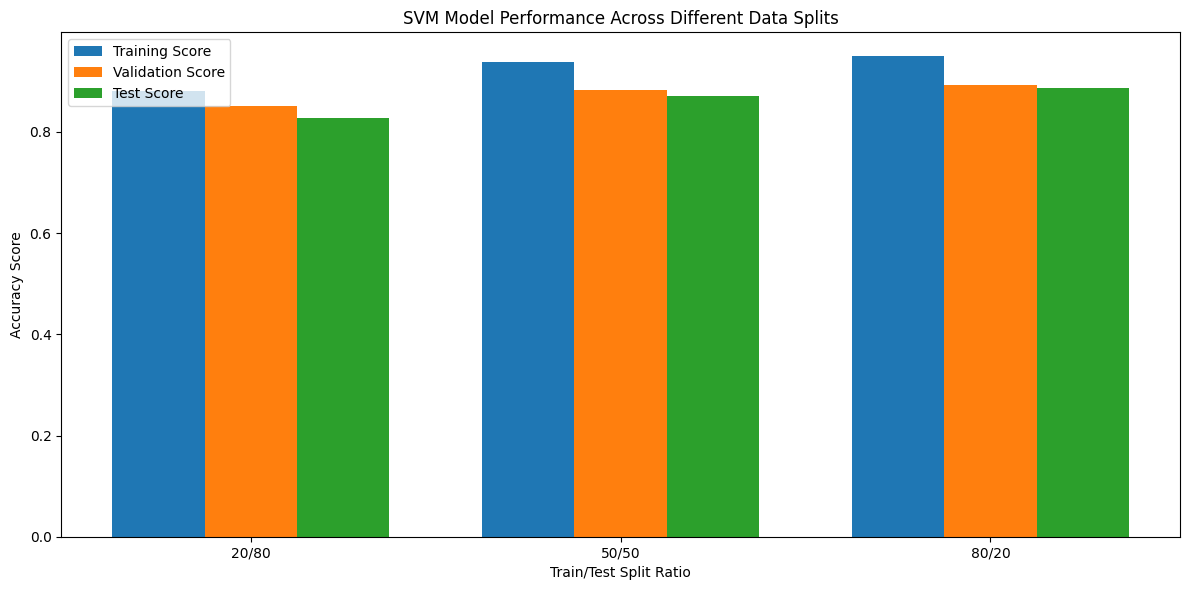

In [6]:
# Print detailed results
for split, res in results.items():
    print(f"\nResults for {split} split:")
    print(f"Average Training Score: {res['avg_train_score']:.4f} ± {res['std_train_score']:.4f}")
    print(f"Average Validation Score: {res['avg_validation_score']:.4f} ± {res['std_validation_score']:.4f}")
    print(f"Average Test Score: {res['avg_test_score']:.4f} ± {res['std_test_score']:.4f}")
    
    # Print best parameters for each trial
    print("\nBest parameters for each trial:")
    for i, trial in enumerate(res['individual_trials']):
        print(f"Trial {i+1}: {trial['best_params']}")
        
    # Print classification report for the last trial
    print("\nDetailed Classification Report (last trial):")
    print(trial_results['classification_report'])

# Visualize results
plt.figure(figsize=(12, 6))
splits = list(results.keys())
train_scores = [res['avg_train_score'] for res in results.values()]
val_scores = [res['avg_validation_score'] for res in results.values()]
test_scores = [res['avg_test_score'] for res in results.values()]

x = np.arange(len(splits))
width = 0.25

plt.bar(x - width, train_scores, width, label='Training Score')
plt.bar(x, val_scores, width, label='Validation Score')
plt.bar(x + width, test_scores, width, label='Test Score')

plt.xlabel('Train/Test Split Ratio')
plt.ylabel('Accuracy Score')
plt.title('SVM Model Performance Across Different Data Splits')
plt.xticks(x, splits)
plt.legend()
plt.tight_layout()
plt.show()